In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

In [2]:
tf.enable_eager_execution()

In [4]:
train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"
train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

8192/2194 [================================================================================================================] - 0s 21us/step


In [6]:
!head -n5 {train_dataset_fp}

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


In [7]:
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

feature_names = column_names[:-1]
label_name = column_names[-1]

In [8]:
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

In [9]:
BATCH_SIZE = 32

In [11]:
train_dataset = tf.data.experimental.make_csv_dataset(
    train_dataset_fp,
    batch_size=BATCH_SIZE,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1
)

In [14]:
features, labels = next(iter(train_dataset))
print(features)
print(labels)

OrderedDict([('sepal_length', <tf.Tensor: id=166, shape=(32,), dtype=float32, numpy=
array([7.6, 5.8, 6.4, 5.8, 5.9, 6.7, 4.6, 4.5, 5.5, 5.7, 6. , 5.4, 4.7,
       5. , 6.7, 4.8, 6.2, 6.4, 5.9, 6.2, 5.1, 6.4, 5.8, 5.7, 5.1, 4.9,
       6.1, 6.3, 5. , 5.2, 4.6, 6.4], dtype=float32)>), ('sepal_width', <tf.Tensor: id=167, shape=(32,), dtype=float32, numpy=
array([3. , 4. , 2.8, 2.7, 3.2, 3. , 3.4, 2.3, 2.4, 3.8, 2.7, 3.4, 3.2,
       3.5, 3. , 3.4, 2.8, 3.2, 3. , 3.4, 3.8, 2.8, 2.7, 3. , 2.5, 2.4,
       2.9, 3.4, 3.4, 3.4, 3.2, 2.7], dtype=float32)>), ('petal_length', <tf.Tensor: id=164, shape=(32,), dtype=float32, numpy=
array([6.6, 1.2, 5.6, 5.1, 4.8, 5. , 1.4, 1.3, 3.7, 1.7, 5.1, 1.5, 1.3,
       1.6, 5.2, 1.6, 4.8, 5.3, 5.1, 5.4, 1.5, 5.6, 5.1, 4.2, 3. , 3.3,
       4.7, 5.6, 1.5, 1.4, 1.4, 5.3], dtype=float32)>), ('petal_width', <tf.Tensor: id=165, shape=(32,), dtype=float32, numpy=
array([2.1, 0.2, 2.1, 1.9, 1.8, 1.7, 0.3, 0.3, 1. , 0.3, 1.6, 0.4, 0.2,
       0.6, 2.3, 0.2, 1.8, 2.

In [17]:
def plot_features(label1, label2):
    plt.scatter(features[label1].numpy(),
                features[label2].numpy(),
                c=labels.numpy(),
                cmap='viridis')
    plt.xlabel(label1)
    plt.ylabel(label2)

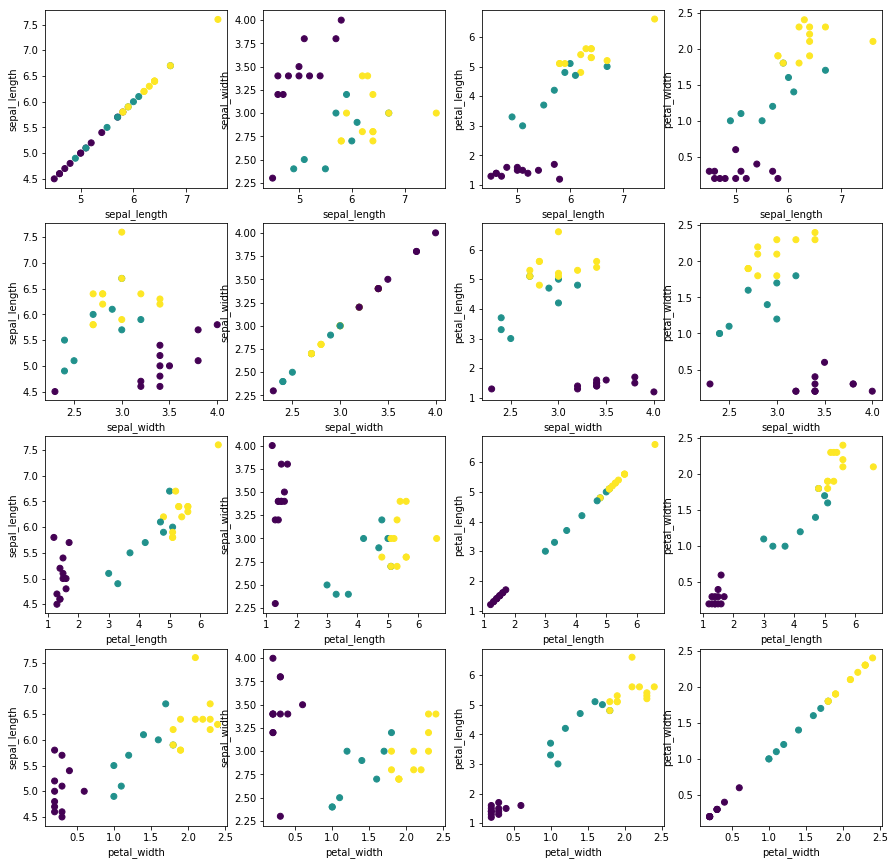

In [21]:
fig = plt.figure(figsize=(15, 15))

i = 1

for label1 in feature_names:
    for label2 in feature_names:
        plt.subplot(4, 4, i)
        plot_features(label1, label2)
        
        i += 1

plt.show()
plt.close(fig)

In [22]:
def pack_features_vector(features, labels):
    features = tf.stack(list(features.values()), axis=1)
    return features, labels

In [23]:
train_dataset = train_dataset.map(pack_features_vector)

In [25]:
features, labels = next(iter(train_dataset))

print(features[:5], labels[:5])

tf.Tensor(
[[6.4 2.8 5.6 2.2]
 [7.7 3.8 6.7 2.2]
 [6.8 3.2 5.9 2.3]
 [6.  2.2 5.  1.5]
 [6.9 3.2 5.7 2.3]], shape=(5, 4), dtype=float32) tf.Tensor([2 2 2 2 2], shape=(5,), dtype=int32)


In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4, )),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(3)
])

In [28]:
predictions = model(features)
predictions[:5]

<tf.Tensor: id=535, shape=(5, 3), dtype=float32, numpy=
array([[-1.043646  , -0.42300442, -0.90687454],
       [-1.1949813 , -0.49555123, -1.1091893 ],
       [-1.0795262 , -0.4510234 , -0.9932208 ],
       [-0.95920885, -0.37860835, -0.70453715],
       [-1.0545135 , -0.4548295 , -1.0255208 ]], dtype=float32)>

In [29]:
def loss(model, x, y):
    y_ = model(x)
    return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)

In [30]:
l = loss(model, features, labels)
l

<tf.Tensor: id=582, shape=(), dtype=float32, numpy=0.9868237>

In [31]:
def grad(model, inputs, targets):
    with tf.GradientTape() as t:
        loss_value = loss(model, inputs, targets)
    return loss_value, t.gradient(loss_value, model.trainable_variables)

In [32]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=1e-2)
global_step = tf.Variable(0)

In [36]:
loss_value, grads = grad(model, features, labels)
print('Step {}: loss {}'.format(global_step.numpy(),
                                 loss_value.numpy()))
optimizer.apply_gradients(zip(grads, model.trainable_variables), global_step)
loss_value, grads = grad(model, features, labels)
print('Step {}: loss {}'.format(global_step.numpy(),
                                loss_value.numpy()))

Step 3: loss 0.9382541179656982
Step 4: loss 0.925629734992981
